In [1]:
import pymaster as nmt
import numpy as np
import healpy as hp
import wget
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.integrate import simpson
%matplotlib inline
import matplotlib
import glass
cmap = plt.get_cmap('twilight_shifted')

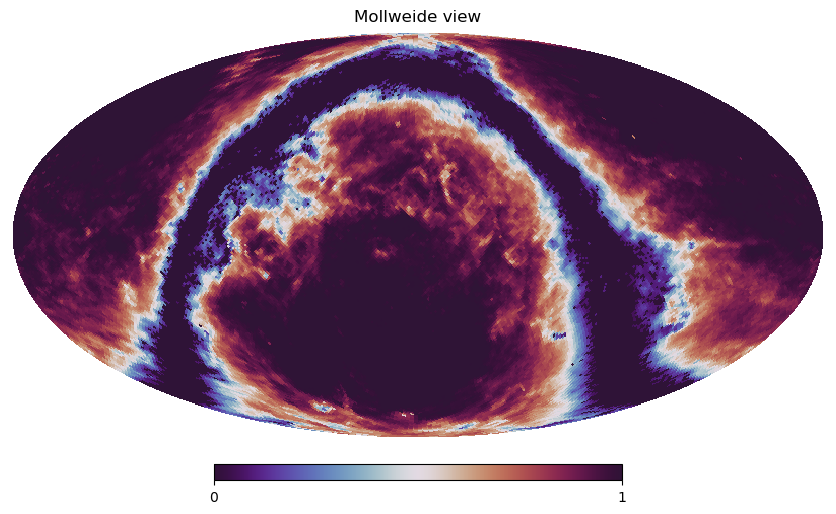

In [18]:
# Download and read selection function
fname_sel = 'selection_function_NSIDE64_G20.5_zsplit2bin0.fits'
if not os.path.isfile(fname_sel):
    wget.download("https://zenodo.org/records/8098636/files/selection_function_NSIDE64_G20.5_zsplit2bin0.fits?download=1")
sel = hp.read_map(fname_sel)

hp.mollview(sel, cmap=cmap)
# Download and read catalog
fname_cat = 'quaia_G20.5.fits'
if not os.path.isfile(fname_cat):
    wget.download("https://zenodo.org/records/10403370/files/quaia_G20.5.fits?download=1")


In [2]:
nside_mask = 512
my_nside = 512
npix = hp.nside2npix(nside_mask)

sel = np.ones(npix)

# theta, phi = hp.pix2ang(nside_mask, np.arange(npix))

# sel = np.sin(theta)

# sel[theta > np.pi / 2] = 0
# sel[phi > np.pi/3*2 ] = 0


cl_extern = np.load("test_cl_dm_gg.npy")
print(cl_extern.shape)


(4999, 6, 6)


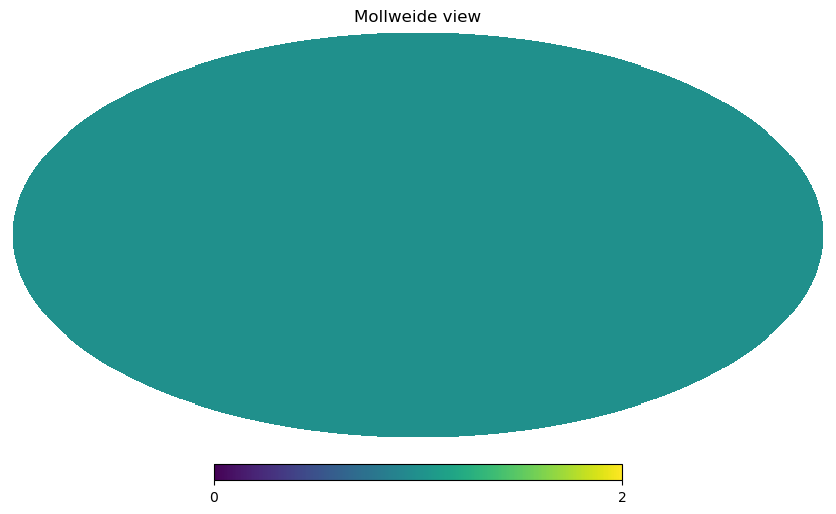

In [3]:
hp.mollview(sel)

In [2]:
def gen_sim_all(spin=0, cl_true = None, nside = None, lmax_nside = None):
    '''this function creates maps starting from the auto or cross correlation between the different input Cells. '''
    cls_list = []
    for i_tomo in range(len(cl_true[0,:,0])):
        for j_tomo in range(i_tomo,len(cl_true[0,:,0])):
            cls_list.append(cl_true[:,i_tomo,j_tomo])
    
    alm = hp.synalm(cls=cls_list)
    map = []
    for i in range(len(alm)):
        map.append(hp.sphtfunc.alm2map(alm[i], nside))
    return map

def gen_fixed_field_all(spin=0,
                        return_map=False,
                        ipix=None,
                        pos_data = None,
                        w_data=None,
                        lmax=None,
                        cl_true = None,
                        nside = None,
                        lmax_nside = None,
                        mp = None,
                        with_noise=None):
    has_map = False
    if mp is None:
        if cl_true is not None:
            aux_map = gen_sim_all(spin=spin, cl_true=cl_true, nside=nside,lmax_nside=lmax_nside)
            mp = []
            fval = []
            fld = []
            for i in range(len(aux_map)):
                mp.append(np.atleast_2d(aux_map[i]))
                if with_noise[i] is not None:
                    nval = np.random.randn(*(mp[i].shape)) * with_noise[i]
                    mp[i] += nval
                fval.append(mp[i][:,ipix[i]])
                fld.append(nmt.NmtFieldCatalog(pos_data[i], w_data[i], fval[i], spin=spin,
                                lmax=lmax, lonlat=True))
            if return_map:
                return fld, mp
            return fld

In [ ]:
map = gen_sim_all(cl_true=cl_extern,nside=16)

In [4]:
def get_pos_all(nsources, nside=None):
    pos_data = []
    if isinstance(nsources, list):
        for i in range(len(nsources)):
            nsources_save = np.copy(nsources[i])
            nsources[i] *= 10
            nside_sel = hp.npix2nside(len(sel))
            th_ran = np.arccos(-1+2*np.random.rand(nsources[i]))
            phi_ran = 2*np.pi*np.random.rand(nsources[i])
            u_ran = np.random.rand(nsources[i])
            ipix_ran = hp.ang2pix(nside_sel, th_ran, phi_ran)
            keep = u_ran <= sel[ipix_ran] #
            pos_data.append(np.array([np.degrees((phi_ran[keep])[:nsources_save]), 90-np.degrees((th_ran[keep])[:nsources_save])]))
    else:
        nsources_save = np.copy(nsources)
        nsources *= 10
        nside_sel = hp.npix2nside(len(sel))
        th_ran = np.arccos(-1+2*np.random.rand(nsources))
        phi_ran = 2*np.pi*np.random.rand(nsources)
        u_ran = np.random.rand(nsources)
        ipix_ran = hp.ang2pix(nside_sel, th_ran, phi_ran)
        keep = u_ran <= sel[ipix_ran] #
        nsrc = nsources_save
        pos_data.append(np.array([np.degrees((phi_ran[keep])[:nsources_save]), 90-np.degrees((th_ran[keep])[:nsources_save])]))
    return pos_data

In [ ]:
pos = get_pos_all([1000,1000,1000,1000,1000, 1000], nside=512)
ipix = []
lmax_nside = 3*my_nside-1
w_data = []
for i in range(len(pos)):
    ipix.append(hp.ang2pix(my_nside, pos[i][0], pos[i][1], lonlat=True))
    w_data.append(np.ones(1000))

fld, mp = gen_fixed_field_all(return_map=True,
                    ipix=ipix,
                    pos_data = pos,
                    w_data=w_data,
                    cl_true=cl_extern,
                    nside=my_nside,
                    lmax_nside = lmax_nside,
                    with_noise=np.zeros(len(pos)),
                    lmax=lmax_nside)

In [5]:
# Simulator
def gen_sim(spin=0, cl_true = None, cl_true_2 = None,cl_true_12 = None, nside = None, lmax_nside = None):
    '''A function tha to generate maps starting form true Cells. if cross correlation exists, it generates maps of two fields, 
    taking the cross correlation into consideration.'''
    
    
    if spin == 0:
        mp = hp.synfast(cl_true, nside)
        if cl_true_2 is not None:
            cls_list = [cl_true, cl_true_12, cl_true_2]
            alm_1, alm_2 = hp.synalm(cls=cls_list)
            map_1 = hp.sphtfunc.alm2map(alm_1, nside)
            map_2 = hp.sphtfunc.alm2map(alm_2, nside)
            return map_1, map_2
    else:
        almE = hp.synalm(cl_true)
        almB = almE*0
        mp = np.array(hp.alm2map_spin([almE, almB], nside,
                                      spin, lmax_nside))
    return mp


# Code to generate simulated fields
def gen_fixed_field(spin=0, return_map=False, ipix_1=None,ipix_2=None, pos_data_1 = None,pos_data_2 = None, w_data=None,
                      w_data_2=None, lmax=None,
                      cl_true = None,cl_true_2 = None,cl_true_12 = None, nside = None, lmax_nside = None , mp_1 = None, mp_2 = None,
                      with_noise_1=None, with_noise_2 = None):
    '''The function generates maps starting from true Cells then constructs NmtFieldCatalog object for field values sampeld on a map. ipix1 correspond to pos_data_1.'''
    has_map = False
    if mp_1 is None:
        if cl_true_2 is not None:
            auxm1, auxm2 = gen_sim(spin=spin, cl_true=cl_true, nside=nside,lmax_nside=lmax_nside,cl_true_2=cl_true_2, cl_true_12 = cl_true_12)
            mp_1 = np.atleast_2d(auxm1)
            mp_2 = np.atleast_2d(auxm2)
            if with_noise_1 is not None:
                nval = np.random.randn(*(mp_1.shape)) * with_noise_1 #adding randoom noise
                mp_1 += nval
            if with_noise_2 is not None:
                nval = np.random.randn(*(mp_2.shape)) * with_noise_2
                mp_2 += nval
        
        else:
            mp_1 = np.atleast_2d(gen_sim(spin=spin, cl_true=cl_true, nside=nside,lmax_nside=lmax_nside))
            if with_noise_1 is not None:
                nval = np.random.randn(*(mp_1.shape)) * with_noise_1
                mp_1 += nval
        
    else:
        has_map = True
    if cl_true_2 is not None:
        
        fval_1 = mp_1[:,ipix_1] # taking the sampled values of the field.
        fval_2 = mp_2[:,ipix_2] # taking the sampled values of the field.
    else:
        fval = mp_1[:, ipix_1] # taking the sampled values of the field.

    if cl_true_2 is not None:
        
        fld_1 = nmt.NmtFieldCatalog(pos_data_1, w_data, fval_1, spin=spin,
                                lmax=lmax, lonlat=True) # constructing the pymaster objects from the sampled field.
        fld_2 = nmt.NmtFieldCatalog(pos_data_2, w_data_2, fval_2, spin=spin,
                                lmax=lmax, lonlat=True)
        if return_map:
            return fld_1, fld_2, mp_1, mp_2
        return fld_1, fld_2
    else:
        fld = nmt.NmtFieldCatalog(pos_data_1, w_data, fval, spin=spin,
                                lmax=lmax, lonlat=True)
        if return_map:
            return fld, mp_1
        return fld


def get_pos(nsources, mode, nside=None):
    nsources_save = np.copy(nsources)
    nsources *= 10
    if mode == 'random' or mode == 'fixed' or mode == "field_variance":        
        nside_sel = hp.npix2nside(len(sel))
        th_ran = np.arccos(-1+2*np.random.rand(nsources))
        phi_ran = 2*np.pi*np.random.rand(nsources)
        u_ran = np.random.rand(nsources)
        ipix_ran = hp.ang2pix(nside_sel, th_ran, phi_ran)
        keep = u_ran <= sel[ipix_ran] #
        nsrc = nsources_save#np.sum(keep)
        # Assign RA, Dec, and weights
        pos_data = np.array([np.degrees((phi_ran[keep])[:nsources_save]), 90-np.degrees((th_ran[keep])[:nsources_save])])
        
    elif mode == 'catalog':
            
        cat = fits.open(fname_cat)[1].data
        # Select only sources with redshifts z < 1.47 (first bin of Alonso et al. 2023)
        cat = cat[cat['redshift_quaia'] < 1.47]

        cat_sel = np.unique(np.random.randint(low=0, high=cat.shape[0], size=nsources))
        cat = cat[cat_sel]
        nsrc = len(cat)
        pos_data = np.array([cat['ra'], cat['dec']])
        
    elif mode == 'hp_grid':
        pos_data = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
        sel_udg = hp.ud_grade(sel, nside_out=nside).astype('bool')
        pos_data = np.array([pos_data[0][sel_udg], pos_data[1][sel_udg]])
        nsrc = pos_data[0].shape[0]
    
    return pos_data, nsrc

def get_snr(mean,cov):
    return np.sqrt(np.sum(np.dot(mean,np.dot(np.linalg.inv(cov),mean))))

In [6]:
cl_extern = np.load("test_cl_dm_gg.npy")
ell_extern = np.arange(len(cl_extern[:,0,0]))
print(cl_extern.shape)


# maps from FRBs and 5th clustering bin.
'''maps = gen_sim(cl_true=cl_extern[:,0,0], cl_true_2=cl_extern[:,-1,-1], cl_true_12=cl_extern[:,-1,0], nside = 256)

for i in range(2):
    for j in range(2):
        cell = hp.anafast(map1=maps[i],map2=maps[j])
        plt.loglog(np.arange(len(cell)), cell)'''

(4999, 6, 6)


'maps = gen_sim(cl_true=cl_extern[:,0,0], cl_true_2=cl_extern[:,-1,-1], cl_true_12=cl_extern[:,-1,0], nside = 256)\n\nfor i in range(2):\n    for j in range(2):\n        cell = hp.anafast(map1=maps[i],map2=maps[j])\n        plt.loglog(np.arange(len(cell)), cell)'

In [7]:
def generate_mocks(cat_sizes,
                   mode,
                   nsims,
                   nside,
                   i_tomo=0,
                   j_tomo=0,
                   lmin = 40,
                   nell = 10,
                   noise_level_i_tomo = None,
                   noise_level_j_tomo = None):
    cross_correlation = False
    if i_tomo != j_tomo:
        cross_correlation = True
    if cross_correlation:
        cl_mean_rnd = []
        cl_prediction =[]
        covmat = []
        field_variance_cov = []
        analytic_cov = []
        npix = hp.nside2npix(nside)
        lmax = 3*nside-1
        lmax_nside = 3*nside-1
        ls = ell_extern[:lmax_nside+1]# np.arange(lmax_nside+1)
        pixwin = hp.pixwin(nside)
        cl_true_1 = cl_extern[:lmax_nside+1,i_tomo, i_tomo]
        cl_true_2 = cl_extern[:lmax_nside+1,j_tomo, j_tomo] # I have corrected this, check the validity
        cl_true_12 = cl_extern[:lmax_nside+1,i_tomo, j_tomo]
        
        field_variance = simpson(cl_true_12*ls,x = ls)/2./np.pi
        field_variance_observed = 0    
        index = 0
        for nsources in cat_sizes:
            if isinstance(nsources, list):
                nsources_1 = nsources[0]
                nsources_2 = nsources[1]
            else:
                nsources_1 = nsources
                nsources_2 = nsources
            if mode=="fixed": # Cell's estimation for one realisation and fixed position. What I did
                pos_data_1, nsrc_1 = get_pos(nsources_1, mode)
                pos_data_2, nsrc_2 = get_pos(nsources_2, mode)
                mp_1, mp_2 = gen_sim(cl_true=cl_true_1,cl_true_2=cl_true_2, cl_true_12 = cl_true_12,nside=nside, lmax_nside = lmax_nside)

                maps = [mp_1, mp_2]
                w_data_1 = np.ones(nsrc_1)
                w_data_2 = np.ones(nsrc_2)

                ipix_1 = hp.ang2pix(nside, pos_data_1[0], pos_data_1[1], lonlat=True)
                ipix_2 = hp.ang2pix(nside, pos_data_2[0], pos_data_2[1], lonlat=True)
                fval_1 = mp_1[ipix_1]
                fval_2 = mp_2[ipix_2]
                fld_1 = nmt.NmtFieldCatalog(pos_data_1, w_data_1, fval_1, lmax=lmax_nside, lonlat=True)
                fld_2 = nmt.NmtFieldCatalog(pos_data_2, w_data_2, fval_2, lmax=lmax_nside, lonlat=True)
                
                edges = np.geomspace(lmin,3*nside,nell).astype(int)
                b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])

                leff = b.get_effective_ells()
                cls = []
                for i in range(nsims):
                    fld_1, fld_2 = gen_fixed_field(ipix_1=ipix_1, ipix_2=ipix_2, pos_data_1=pos_data_1,pos_data_2=pos_data_2,w_data=w_data_1,w_data_2=w_data_2,lmax=lmax,
                                            cl_true=cl_true_1,cl_true_2=cl_true_2, cl_true_12 = cl_true_12,nside=nside, lmax_nside = lmax_nside,
                                            with_noise_1 = noise_level_i_tomo,
                                            with_noise_2 = noise_level_j_tomo)
                    w = nmt.NmtWorkspace.from_fields(fld_1, fld_2, b)
                    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld_1, fld_2)))
                cls = np.array(cls)
            if mode=="random": # Cell estimation for variable positions and variable realisations
                pos_data_1, nsrc_1 = get_pos(nsources_1, mode)
                pos_data_2, nsrc_2 = get_pos(nsources_2, mode)
                w_data_1 = np.ones(nsrc_1)
                w_data_2 = np.ones(nsrc_2)

                mp_1, mp_2 = gen_sim(cl_true=cl_true_1,cl_true_2=cl_true_2,nside=nside, lmax_nside = lmax_nside)
                ipix_1 = hp.ang2pix(nside, pos_data_1[0], pos_data_1[1], lonlat=True)
                ipix_2 = hp.ang2pix(nside, pos_data_2[0], pos_data_2[1], lonlat=True)
                fval_1 = mp_1[ipix_1]
                fval_2 = mp_2[ipix_2]
                fld_1 = nmt.NmtFieldCatalog(pos_data_1, w_data_1, fval_1, lmax=lmax_nside, lonlat=True)
                fld_2 = nmt.NmtFieldCatalog(pos_data_2, w_data_2, fval_2, lmax=lmax_nside, lonlat=True)
                
                edges = np.geomspace(40,3*nside,10).astype(int)
                b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])

                leff = b.get_effective_ells()
                
                cls = []
                for i in range(nsims):
                    pos_data_1, nsrc = get_pos(nsources_1, mode)
                    pos_data_2, nsrc = get_pos(nsources_2, mode)
                    ipix_1 = hp.ang2pix(nside, pos_data_1[0], pos_data_1[1], lonlat=True)
                    ipix_2 = hp.ang2pix(nside, pos_data_2[0], pos_data_2[1], lonlat=True)
                    fld_1, fld_2 = gen_fixed_field(ipix_1=ipix_1,ipix_2=ipix_2, pos_data_1=pos_data_1,pos_data_2=pos_data_2,w_data=w_data_1,w_data_2=w_data_2,lmax=lmax,
                                            cl_true=cl_true_1,cl_true_2=cl_true_2, cl_true_12 = cl_true_12,nside=nside, lmax_nside = lmax_nside,
                                            with_noise_1 = noise_level_i_tomo,
                                            with_noise_2 = noise_level_j_tomo)
                    w = nmt.NmtWorkspace.from_fields(fld_1, fld_2, b)
                    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld_1, fld_2)))
                cls = np.array(cls)

            if mode=="field_variance": #same field values, different positions. I am fixing ipix and the map while chanigng the input positions.
                pos_data_1, nsrc_1 = get_pos(nsources_1, mode)
                pos_data_2, nsrc_2 = get_pos(nsources_2, mode)
                w_data_1 = np.ones(nsrc_1)
                w_data_2 = np.ones(nsrc_2)

                
                ipix_1 = hp.ang2pix(nside, pos_data_1[0], pos_data_1[1], lonlat=True)
                ipix_2 = hp.ang2pix(nside, pos_data_2[0], pos_data_2[1], lonlat=True)
                edges = np.geomspace(lmin,3*nside,nell).astype(int)
                b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
                leff = b.get_effective_ells()
                
                fld_1, fld_2, map_fixed_1, map_fixed_2 = gen_fixed_field(ipix_1=ipix_1,ipix_2=ipix_2, pos_data_1=pos_data_1,pos_data_2=pos_data_2,w_data=w_data_1,w_data_2=w_data_2,lmax=lmax,
                                            cl_true=cl_true_1,cl_true_2=cl_true_2,nside=nside,  cl_true_12 = cl_true_12,lmax_nside = lmax_nside, return_map=True,
                                            with_noise_1 = noise_level_i_tomo,
                                            with_noise_2 = noise_level_j_tomo)
                cls = []
                w = nmt.NmtWorkspace.from_fields(fld_1, fld_2, b)                
                for i in range(nsims):

                    pos_data_1, nsrc = get_pos(nsources_1, mode)
                    pos_data_2, nsrc = get_pos(nsources_2, mode)
                    #ipix_1 = hp.ang2pix(nside, pos_data_1[0], pos_data_1[1], lonlat=True)
                    #ipix_2 = hp.ang2pix(nside, pos_data_2[0], pos_data_2[1], lonlat=True)
                    fld_1, fld_2 = gen_fixed_field(ipix_1=ipix_1,ipix_2=ipix_2, pos_data_1=pos_data_1,pos_data_2=pos_data_2,w_data=w_data_1,w_data_2=w_data_2,lmax=lmax,
                                            cl_true=cl_true_1,cl_true_2=cl_true_2, cl_true_12 = cl_true_12,nside=nside, lmax_nside = lmax_nside, mp_1=map_fixed_1, mp_2=map_fixed_2, 
                                            with_noise_1 = noise_level_i_tomo,
                                            with_noise_2 = noise_level_j_tomo)
                    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld_1, fld_2)))
                cls = np.array(cls)

            if mode=="chime": #same field realisations, shuffled positions.
                pos_data_1, nsrc_1 = get_pos(nsources_1, "fixed")
                pos_data_2, nsrc_2 = get_pos(nsources_2, "fixed")
                w_data_1 = np.ones(nsrc_1)
                w_data_2 = np.ones(nsrc_2)

                
                ipix_1 = hp.ang2pix(nside, pos_data_1[0], pos_data_1[1], lonlat=True)
                ipix_2 = hp.ang2pix(nside, pos_data_2[0], pos_data_2[1], lonlat=True)
                edges = np.geomspace(lmin,3*nside,nell).astype(int)
                b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])

                leff = b.get_effective_ells()
                
                #leff = b.get_effective_ells()
                fld_1, fld_2, map_fixed_1, map_fixed_2 = gen_fixed_field(ipix_1=ipix_1,ipix_2=ipix_2, pos_data_1=pos_data_1,pos_data_2=pos_data_2,w_data=w_data_1,w_data_2=w_data_2,lmax=lmax,
                                            cl_true=cl_true_1,cl_true_2=cl_true_2,nside=nside,  cl_true_12 = cl_true_12,lmax_nside = lmax_nside, return_map=True,
                                            with_noise_1 = noise_level_i_tomo,
                                            with_noise_2 = noise_level_j_tomo)
                cls = []
                w = nmt.NmtWorkspace.from_fields(fld_1, fld_2, b)                
                for i in range(nsims):
                    np.random.shuffle(pos_data_1[0,:])
                    np.random.shuffle(pos_data_1[1,:])
                    fld_1, fld_2 = gen_fixed_field(ipix_1=ipix_1,ipix_2=ipix_2, pos_data_1=pos_data_1,pos_data_2=pos_data_2,w_data=w_data_1,w_data_2=w_data_2,lmax=lmax,
                                            cl_true=cl_true_1,cl_true_2=cl_true_2, cl_true_12 = cl_true_12,nside=nside, lmax_nside = lmax_nside, mp_1=map_fixed_1, mp_2=map_fixed_2, 
                                            with_noise_1 = noise_level_i_tomo,
                                            with_noise_2 = noise_level_j_tomo)
                    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld_1, fld_2)))
                cls = np.array(cls)

            cl_pred = w.decouple_cell(w.couple_cell([cl_true_12*pixwin**2]))
            cl_prediction.append(cl_pred[0,:])
            cl_mean = np.mean(cls, axis=0)
            cl_mean_rnd.append(cl_mean[0])
            delta_ell = np.zeros_like(leff)
            delta_ell[:-1] = leff[1:] - leff[:-1]
            delta_ell[-1] = delta_ell[-2]
            covmat.append(np.cov((cls[:,index,:]).T))
            ndens_sources = np.sqrt(nsources_1*nsources_2)/4.0/np.pi
            analytic_cov.append(2*(cl_pred[0,:]+ field_variance/ndens_sources)**2/(2*leff + 1)/delta_ell)
            field_variance_cov.append((field_variance/ndens_sources)**2/(2*leff + 1)/delta_ell)
        return leff, cl_mean_rnd, cl_prediction, covmat, analytic_cov, field_variance_cov, cls
    else:
        cl_mean_rnd = []
        cl_prediction =[]
        covmat = []
        field_variance_cov = []
        analytic_cov = []
        npix = hp.nside2npix(nside)
        lmax = 3*nside-1
        lmax_nside = 3*nside-1
        ls = ell_extern[:lmax_nside+1]# np.arange(lmax_nside+1)
        pixwin = hp.pixwin(nside)
        cl_true = cl_extern[:lmax_nside+1,i_tomo, j_tomo] #1/(ls+10)**exponent
        field_variance = simpson(cl_true*ls,x = ls)/2./np.pi    

        index = 0
        for nsources in cat_sizes:
            if mode=="fixed":
                pos_data, nsrc = get_pos(nsources, mode)
                    
                # print(f"The catalog has {nsrc} sources.")
                mp = gen_sim(cl_true=cl_true,nside=nside, lmax_nside = lmax_nside)

                # Catalog weights
                w_data = np.ones(nsrc)

                # Generate continuous map
                # Calculate pixel indices for each souce
                ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)
                # Assign field values from sky positions
                fval = mp[ipix]

                fld = nmt.NmtFieldCatalog(pos_data, w_data, fval, lmax=lmax_nside, lonlat=True)
                
                edges = np.geomspace(lmin,3*nside,nell).astype(int)
                b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
                
                cls = []
                w = nmt.NmtWorkspace.from_fields(fld, fld, b)
                for i in range(nsims):
                    fld = gen_fixed_field(ipix_1=ipix, pos_data_1=pos_data,w_data=w_data,lmax=lmax,
                                            cl_true=cl_true,nside=nside, lmax_nside = lmax_nside)
                    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld, fld)))
                cls = np.array(cls)
            if mode=="random":
                pos_data, nsrc = get_pos(nsources, mode)
                cls = []
                # Catalog weights
                w_data = np.ones(nsrc)

                # Generate continuous map
                mp = gen_sim(cl_true=cl_true,nside=nside, lmax_nside = lmax_nside)
                # Calculate pixel indices for each souce
                ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)
                # Assign field values from sky positions
                fval = mp[ipix]
                fld = nmt.NmtFieldCatalog(pos_data, w_data, fval, lmax=lmax_nside, lonlat=True)
                
                edges = np.geomspace(lmin,3*nside,nell).astype(int)
                b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
                cls = []
                for i in range(nsims):
                    pos_data, nsrc = get_pos(nsources, mode)
                    ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)    
                    
                    fld = gen_fixed_field(ipix_1=ipix, pos_data_1=pos_data,w_data=w_data,lmax=lmax,
                                            cl_true=cl_true,nside=nside, lmax_nside = lmax_nside)
                    w = nmt.NmtWorkspace.from_fields(fld, fld, b)

                    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld, fld)))
                cls = np.array(cls)

            if mode=="field_variance":
                pos_data, nsrc = get_pos(nsources, mode)
                cls = []
                # Catalog weights
                w_data = np.ones(nsrc)

                # Generate continuous map
                mp = gen_sim(cl_true=cl_true,nside=nside, lmax_nside = lmax_nside)
                # Calculate pixel indices for each souce
                ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)
                # Assign field values from sky positions
                fval = mp[ipix]
                fld = nmt.NmtFieldCatalog(pos_data, w_data, fval, lmax=lmax_nside, lonlat=True)
                
                edges = np.geomspace(lmin,3*nside,nell).astype(int)
                b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
                leff = b.get_effective_ells()
                fld, map_fixed = gen_fixed_field(ipix_1=ipix, pos_data_1=pos_data,w_data=w_data,lmax=lmax,
                                            cl_true=cl_true,nside=nside, lmax_nside = lmax_nside, return_map=True)
                w = nmt.NmtWorkspace.from_fields(fld, fld, b)
                for i in range(nsims):
                    pos_data, nsrc = get_pos(nsources, mode)
                    # IF YOU UNCOMMENT THIS; YOU WILL NOT GET THE FIELD VARIANCE
                    #ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)
    

                    fld = gen_fixed_field(ipix_1=ipix, pos_data_1=pos_data,w_data=w_data,lmax=lmax,
                                            cl_true=cl_true,nside=nside, lmax_nside = lmax_nside, mp_1=map_fixed)

                    cls.append(w.decouple_cell(nmt.compute_coupled_cell(fld, fld)))
                cls = np.array(cls)

            leff = b.get_effective_ells()
            cl_pred = w.decouple_cell(w.couple_cell([cl_true*pixwin**2]))
            cl_prediction.append(cl_pred[0,:])
            cl_mean = np.mean(cls, axis=0)
            cl_mean_rnd.append(cl_mean[0])
            delta_ell = np.zeros_like(leff)
            delta_ell[:-1] = leff[1:] - leff[:-1]
            delta_ell[-1] = delta_ell[-2]
            covmat.append(np.cov((cls[:,index,:]).T))
            ndens_sources = nsources/4.0/np.pi
            analytic_cov.append(2*(cl_pred[0,:]+ field_variance/ndens_sources)**2/(2*leff + 1)/delta_ell)
            field_variance_cov.append(2*(field_variance/ndens_sources)**2/(2*leff + 1)/delta_ell)
        return leff, cl_mean_rnd, cl_prediction, covmat, analytic_cov, field_variance_cov, cls



In [12]:
import healpy as hp
# from utils import *
my_nside = 512
npix = hp.nside2npix(my_nside)

sel = np.ones(npix)



Nsim = 20
nell  = 10
nside = 64
lmin = 10
cl_extern = np.load("test_cl_dm_gg.npy")
ell_extern = np.arange(len(cl_extern[:,0,0]))








def f1(i, j, cat_size):
    leff_variance_auto, cl_mean_rnd_variance_auto, cl_prediction_variance_auto, covmat_variance_auto, analytic_cov_variance_auto, field_variance_cov_variance_auto, cls_auto = generate_mocks(cat_sizes=cat_size,
                                                                             mode="field_variance",
                                                                             nsims=100,
                                                                             nell=nell,
                                                                             lmin = lmin, 
                                                                            i_tomo=i,
                                                                            j_tomo=j,
                                                                             nside=nside)
    return cl_prediction_variance_auto[0], cl_mean_rnd_variance_auto[0], np.diag(covmat_variance_auto[0]), analytic_cov_variance_auto[0], leff_variance_auto


In [13]:
_, _, sigma_field_variance, sigms_pred, ells = f1(1,2, [[int(1e3), int(1e5)]]) 


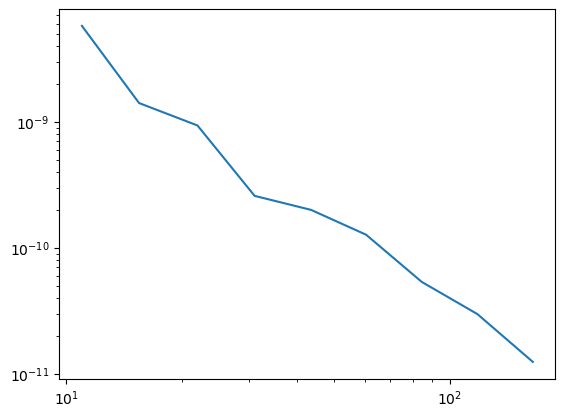

In [ ]:
plt.loglog(ells, sigma_field_variance )
plt.loglog(ells, sigms_pred)

In [63]:
cat_size = [int(1e3), int(1e3)]
nside = 32
nell = 30
lmin = 20

cls_prediction_list = []
cls_fixed_field_list = []
cls_field_variance_list = []

var_prediction_list = []
var_fixed_field_list = []
var_field_variance_list = []





from tqdm import tqdm

for i in tqdm(range(3)):
    for j in range(i + 1):
        print(i, j, 'done')
        leff_variance_auto, cl_mean_rnd_variance_auto, cl_prediction_variance_auto, covmat_variance_auto, analytic_cov_variance_auto, field_variance_cov_variance_auto, cls_auto = generate_mocks(cat_sizes=cat_size,
                                                                             mode="field_variance",
                                                                             nsims=100,
                                                                             nell=nell,
                                                                             lmin = lmin, 
                                                                            i_tomo=i,
                                                                            j_tomo=j,
                                                                             nside=nside)
        leff_fixed_auto, cl_mean_rnd_fixed_auto, cl_prediction_fixed_auto, covmat_fixed_auto, analytic_cov_fixed_auto, field_variance_cov_fixed_auto,cls_auto  = generate_mocks(cat_sizes=cat_size,
                                                                             mode="fixed",
                                                                             nsims=100,
                                                                             nell=nell,
                                                                             lmin = lmin,
                                                                             i_tomo=i,
                                                                            j_tomo=j,
                                                                             nside=nside)
        '''leff_random_auto, cl_mean_rnd_random_auto, cl_prediction_random_auto, covmat_random_auto, analytic_cov_random_auto, field_variance_cov_random_auto,cls_auto = generate_mocks(cat_sizes=cat_size,
                                                                             mode="random",
                                                                             nsims=100,
                                                                             i_tomo=i,
                                                                            j_tomo=j,
                                                                             exponent=1,
                                                                             nside=nside)'''
        cls_prediction_list.append(cl_prediction_variance_auto[0])
        cls_fixed_field_list.append(cl_mean_rnd_variance_auto[0])
        cls_field_variance_list.append(cl_mean_rnd_fixed_auto[0])

        var_prediction_list.append(np.diag(analytic_cov_fixed_auto[0]))
        var_fixed_field_list.append(np.diag(covmat_fixed_auto[0]))
        var_field_variance_list.append(np.diag(covmat_variance_auto[0]))

  0%|          | 0/3 [00:00<?, ?it/s]

0 0 done


 33%|███▎      | 1/3 [00:14<00:28, 14.25s/it]

1 0 done
[0.01616834 0.01590536 0.01350218 0.01089023 0.00879622 0.00732994
 0.00633622 0.00560654 0.00500216 0.00445996 0.00398166 0.00356988
 0.00322269 0.0029296  0.00266913 0.00243409 0.00222805 0.00204604
 0.00189403 0.00176603 0.00165601 0.00156283 0.00147822 0.0013967
 0.00132518 0.00125137 0.00118522 0.00112515 0.00106543 0.00101473
 0.00097016 0.00092749 0.00088778 0.00085484 0.00082382 0.00079214
 0.00076305 0.00073677 0.00071367 0.00069014 0.00066755 0.00064658
 0.00062687 0.00060848 0.00059071 0.00057352 0.00055806 0.0005433
 0.00052972 0.00051724 0.00050536 0.00049396 0.00048301 0.00047241
 0.00046202 0.00045201 0.00044247 0.00043335 0.00042474 0.0004168
 0.00040911 0.00040166 0.00039461 0.00038783 0.00038126 0.00037491
 0.00036881 0.00036289 0.00035715 0.00035168 0.00034635 0.00034118
 0.00033615 0.00033131 0.00032667 0.00032216 0.00031785 0.00031366
 0.0003096  0.00030563 0.00030177 0.00029803 0.00029438 0.00029081
 0.00028732 0.00028392 0.00028059 0.00027737 0.00027423 

 67%|██████▋   | 2/3 [01:15<00:42, 42.17s/it]

2 0 done
[1.52352474e-03 1.90595674e-03 2.02848746e-03 2.00090259e-03
 1.88837326e-03 1.73443963e-03 1.56705806e-03 1.40397566e-03
 1.25542144e-03 1.12663854e-03 1.01847859e-03 9.29387835e-04
 8.56597507e-04 7.96836730e-04 7.46533090e-04 7.02494767e-04
 6.62883690e-04 6.26666806e-04 5.91551650e-04 5.58478123e-04
 5.27180373e-04 4.97776245e-04 4.70033051e-04 4.45015672e-04
 4.21257075e-04 4.00132264e-04 3.80196219e-04 3.62051587e-04
 3.44911641e-04 3.29200038e-04 3.13823388e-04 2.99711277e-04
 2.86235900e-04 2.73753812e-04 2.62142329e-04 2.51193932e-04
 2.41424825e-04 2.32385057e-04 2.24073149e-04 2.16522223e-04
 2.09571707e-04 2.03170586e-04 1.97125477e-04 1.91126398e-04
 1.85789651e-04 1.80634413e-04 1.75456106e-04 1.70368306e-04
 1.65555061e-04 1.60784536e-04 1.56366254e-04 1.52168022e-04
 1.47804537e-04 1.43627132e-04 1.39779722e-04 1.36162856e-04
 1.32701510e-04 1.29248846e-04 1.26073827e-04 1.22923858e-04
 1.19900912e-04 1.17099547e-04 1.14530669e-04 1.12032199e-04
 1.09629476e-04

100%|██████████| 3/3 [03:07<00:00, 62.62s/it]


In [9]:
leff_variance_auto, cl_mean_rnd_variance_auto, cl_prediction_variance_auto, covmat_variance_auto, analytic_cov_variance_auto, field_variance_cov_variance_auto, cls_auto = generate_mocks(cat_sizes=[10000],
                                                                             mode="field_variance",
                                                                             nsims=100,
                                                                             i_tomo=2,
                                                                             j_tomo=3,
                                                                            

                                                                             nside=32)

'''leff_random_auto, cl_mean_rnd_random_auto, cl_prediction_random_auto, covmat_random_auto, analytic_cov_random_auto, field_variance_cov_random_auto,cls_auto = generate_mocks(cat_sizes=[10000],
                                                                             mode="random",
                                                                             nsims=100,
                                                                             exponent=1,
                                                                             nside=256)'''

leff_fixed_auto, cl_mean_rnd_fixed_auto, cl_prediction_fixed_auto, covmat_fixed_auto, analytic_cov_fixed_auto, field_variance_cov_fixed_auto,cls_auto  = generate_mocks(cat_sizes=[10000],
                                                                             mode="fixed",
                                                                             i_tomo=2,
                                                                             j_tomo=3,
                                                                             nsims=100,
                                                                             nside=32)


In [10]:
len(covmat_variance_auto)

1

In [70]:
np.save('cls_pred.npy', cls_prediction_list)
np.save('cls_fixed_field.npy', cls_fixed_field_list)
np.save('cls_field_variance.npy', cls_field_variance_list)

np.save('sigma_pred.npy', var_prediction_list)
np.save('sigma_fixed_field.npy', var_fixed_field_list)
np.save('sigma_field_variance.npy', var_field_variance_list)

np.save('ells.npy', leff_fixed_auto)


Text(0, 0.5, '$C_\\ell$')

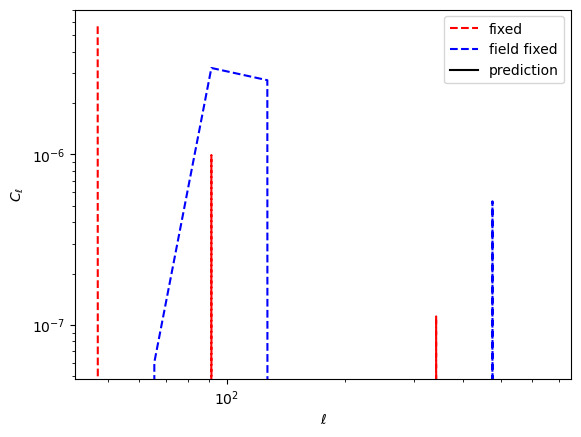

In [66]:
#plt.loglog(leff_random_auto,cl_mean_rnd_random_auto[0], color= "green", label = r"random")

plt.loglog(leff_fixed_auto,cl_mean_rnd_fixed_auto[0], ls = "--", color= "red",  label = r"fixed")

plt.loglog(leff_fixed_auto, cl_mean_rnd_variance_auto[0], ls = "--", color= "blue",  label = r"field fixed")


plt.loglog(leff_fixed_auto, cl_prediction_fixed_auto[0], color = "black", label = r"prediction")


plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

In [ ]:

plt.loglog(leff_fixed_auto,(field_variance_cov_variance_auto[0]), label = "field variance", color = "black")


plt.loglog(leff_fixed_auto,np.diag(covmat_fixed_auto[0]), ls = "--", label = "fixed", color = "red")


plt.loglog(leff_variance_auto,np.diag(covmat_variance_auto[0]), ls = "--", label = "field fixed", color = "blue")


plt.legend()



print(get_snr(cl_mean_rnd_fixed_auto[0],covmat_fixed_auto[0]))

In [ ]:
print(cls_auto.shape)

plt.errorbar(leff_fixed_auto, cls_auto[0,0,:],np.diag(covmat_variance_auto[0])**.5)

plt.xscale("log")
plt.yscale("log")

In [ ]:

Nreal = 50

leff_chime_cross, cl_mean_rnd_chime_cross, cl_prediction_chime_cross, covmat_chime_cross, analytic_cov_chime_cross, field_variance_cov_chime_cross, cls_cross_chime = generate_mocks(cat_sizes=[100000,2000000],
                                                                             mode="chime",
                                                                             nsims=Nreal,
                                                                             nside=512, i_tomo = 0, j_tomo = -1,
                                                                             noise_level_i_tomo=0,
                                                                             noise_level_j_tomo=0)

leff_fixed_cross, cl_mean_rnd_fixed_cross, cl_prediction_fixed_cross, covmat_fixed_cross, analytic_cov_fixed_cross, field_variance_cov_fixed_cross, cls_cross = generate_mocks(cat_sizes=[100000,2000000],
                                                                             mode="fixed",
                                                                             nsims=Nreal,
                                                                             nside=512, i_tomo = 0, j_tomo = -1,
                                                                             noise_level_i_tomo=0,
                                                                             noise_level_j_tomo=0)



leff_variance_cross, cl_mean_rnd_variance_cross, cl_prediction_variance_cross, covmat_variance_cross, analytic_cov_variance_cross, field_variance_cov_variance_cross, cls_cross_variance = generate_mocks(cat_sizes=[100000,2000000],
                                                                             mode="field_variance",
                                                                             nsims=Nreal,
                                                                             nside=512, i_tomo = 0, j_tomo = -1,
                                                                             noise_level_i_tomo=0,
                                                                             noise_level_j_tomo=0)




In [ ]:

plt.errorbar(leff_fixed_cross,cl_mean_rnd_fixed_cross[0],np.sqrt(np.diag(covmat_fixed_cross[0])/Nreal), ls = "--", color= "red",  label = r"fixed")

plt.errorbar(leff_fixed_cross,cl_mean_rnd_chime_cross[0],np.sqrt(np.diag(covmat_chime_cross[0])/Nreal), ls = "-", color= "blue",  label = r"chime")


#plt.loglog(leff_fixed_cross,cl_mean_rnd_variance_cross[0], ls = "--", color= "blue",  label = r"field fixed")


plt.semilogx(leff_fixed_cross,cl_prediction_fixed_cross[0], color = "black", label = r"prediction")

plt.yscale("log")

plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

In [ ]:
#plt.loglog(leff_fixed_cross,(field_variance_cov_fixed_cross[0]), label = "field variance", color = "black")

plt.loglog(leff_fixed_cross,np.diag(covmat_fixed_cross[0]), ls = "--", label = "fixed", color = "red")
plt.loglog(leff_chime_cross,np.diag(covmat_chime_cross[0]), ls = "-", label = "chime", color = "red")

plt.loglog(leff_chime_cross,np.diag(covmat_variance_cross[0]), ls = "-", label = "field variance", color = "blue")

#plt.loglog(leff_variance_cross,np.diag(covmat_variance_cross[0]), ls = "--", label = "field fixed", color = "blue")

plt.legend()
hartlap = (Nreal - len(leff_fixed_cross) - 2 )/(Nreal - 1)

print(hartlap*get_snr(cl_mean_rnd_fixed_cross[0],covmat_fixed_cross[0]))

corr = covmat_fixed_cross[0]/np.sqrt(np.diag(covmat_fixed_cross[0])[:,None]*np.diag(covmat_fixed_cross[0])[None,:])


In [ ]:
dm_host_variance = 50**2
dm_host_median = 50

mu = np.log(dm_host_median**2/(np.sqrt(dm_host_median**2 + dm_host_variance)))
sigma2 = np.log(1 + dm_host_variance / dm_host_median**2)
sigma = np.sqrt(sigma2)

samples = np.random.lognormal(mu,sigma,100000)



print(np.mean(samples))
